# Collective states in dipole arrays

In this example we look at the radiation pattern and tansport behaviour of collective states in arrays of two-level emitters.

As usual the time evolution of the atoms is governed by the master equation $\dot{\rho} = -i [H,\rho] + \mathcal{L}[\rho]$. The Hamiltonian in a frame rotating at the atomic transition frequency $\omega_0$ reads

$ H  = \sum_{i\neq j} \Omega_{ij} \sigma^-_i \sigma^+_j$,

and the Lindblad operator is

$\mathcal{L}[\rho] = \frac{1}{2}\sum_{i,j}\Gamma_{ij}(2\sigma^-_i\rho \sigma^+_j - \sigma^+_i\sigma^-_j \rho - \rho \sigma^+_i \sigma^-_j)$.

In an analogy to the example "Super- and subradiance of two dipoles" we again consider the single excitation manifold and us the effective Hamiltonian formalism to calculate numerically the eigenstates of the system.

First we load the necessary libraries.

In [1]:
using QuantumOptics, PyPlot, CollectiveSpins

Next we define the parameters, operators, basis and the geometry for two rings with 10 emitters each. Here  we choose a tangential polarization for the dipole transitions.

In [2]:
N1 = 10
Γ0 = 1.0
d = 0.1
k0 = 2pi # corresponds to λ=1

# Ring Geometry
ϕ(j) = 2π/N1*(j-1) # Angle separating atoms
Rot(φ) = [cos(φ) -sin(φ) 0;sin(φ) cos(φ) 0; 0 0 1] # Tangential polarization
R = d/sin((ϕ(2)))
pos = [[R*cos(ϕ(j)), R*sin(ϕ(j)), 0.0] for j=1:N1];
dips = [normalize(Rot(pi/2)*pos[i]) for i=1:N1];

# add second ring
for i = 1:N1
    push!(pos,pos[i]+[0.0,2R+1.5d,0.0])
    push!(dips,normalize(Rot(-pi/2)*pos[i]))
end

N2 = length(pos)
b = NLevelBasis(N2)
sm(i) = transition(b, N2, i)
sp(i) = transition(b, i, N2)
σ = sm.([1:N2;])
σp = sp.([1:N2;]);

The collective dipole and decay matrix elements can be generated via the CollectiveSpins.jl package. In this example we start with the most subradiant state of the first ring and let the state evolve in time. For the N-ring with tangential polarizations for the emitters this state can be written as 

$|\psi_{sub}\rangle = N^{-1/2} \sum^N_k e^{ik\pi}\sigma_k^+ |g\rangle$.

As previously we also calculate the output field $E^+(\vec{r}) = \frac{|\vec{\mu}|k_0^2}{\epsilon_0}\sum_i G(\vec{r}-\vec{r_i},\omega_0)\cdot \vec{\mu}_i\sigma^-_i$ of the system and then the intensity $I(\vec{r}) = \langle E^+ E^- \rangle$ at a point $\vec{r}$.

In [7]:
Ω(i,j) = Omega_ij(pos[i],pos[j],dips[i],dips[j],k0)
Γ(i,j) = Gamma_ij(pos[i],pos[j],dips[i],dips[j],k0)

# Eigenstates for the 1. ring
Heff = sum((Ω(i,j)-1im*Γ(i,j)*0.5)*sp(i)*sm(j) for i=1:N1,j=1:N1) 
λ = eigenstates(dense(Heff))
psi0 = λ[2][end]

# Time evolution for both rings
tspan = [0.0:0.1:50;]
Heff = sum((Ω(i,j)-1im*Γ(i,j)*0.5)*sp(i)*sm(j) for i=1:N2,j=1:N2)
tout,psit = timeevolution.schroedinger(tspan,psi0,Heff)

function Ep(r,N)
     # Create vector of operators
    out = [0*transition(NLevelBasis(N), N, N) for i=1:3]
    for i=1:N
        # Compute product of G with pᵢ
        G_ = GreenTensor(r - pos[i], k0)
        Gpi = (G_ * dips[i])
        @inbounds for j=1:3
            out[j].data .+= sm(i).data .* Gpi[j]
        end
    end
    out
end

function Intensity(r,N)
    E = Ep(r,N)
    sum(dagger(e)*e for e=E)
end

I_exp(r, ψ) = real(expect(Intensity(r,N2), ψ))

I_exp (generic function with 1 method)

Finally a grid for the radiation field is defined and the instances of time are chosen such that the excitation is either almost completely in ring one or two.

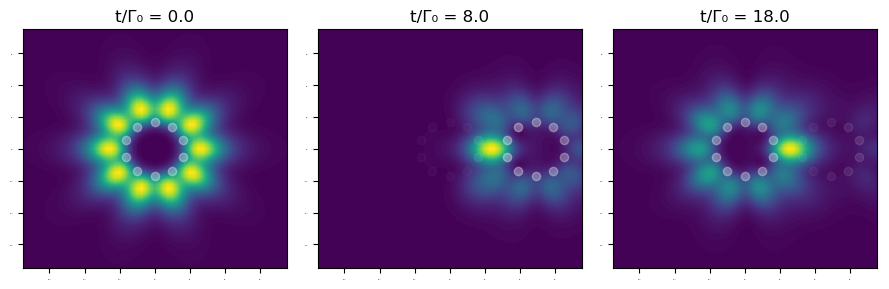

In [8]:
# Define grid
xmin = -0.75 ; xmax = 0.75;
x = collect(range(-xmax, stop=xmax, length=61))
y = collect(range(-xmax, stop=xmax, length=61))
z = 1.5R
grid = [[x1, y1, z1] for x1=x, y1=y, z1=z];

figure(figsize=(9, 3))
kspan = [1,81,181]
for k = 1:3
    t = kspan[k];t2 = tout[t]
    I_profile = [I_exp(gr, psit[t]) for gr=grid];
    subplot(1,3,k)
    title("t/Γ₀ = $t2")
    contourf(y, x, I_profile, 100,cmap="viridis")
    for i = 1:N2
        alpha_ = abs(dagger(nlevelstate(b,i))*psit[t])
        plot(pos[i][2],pos[i][1],"wo",markersize=6,alpha=alpha_)
    end
    tick_params(labelsize=0)
    tight_layout()
end

To look more closely at the transport behaviour of the two rings we define a projector which counts only excitations in the second ring and look at its time evolution for the 5 most subradiant states starting in the first ring.

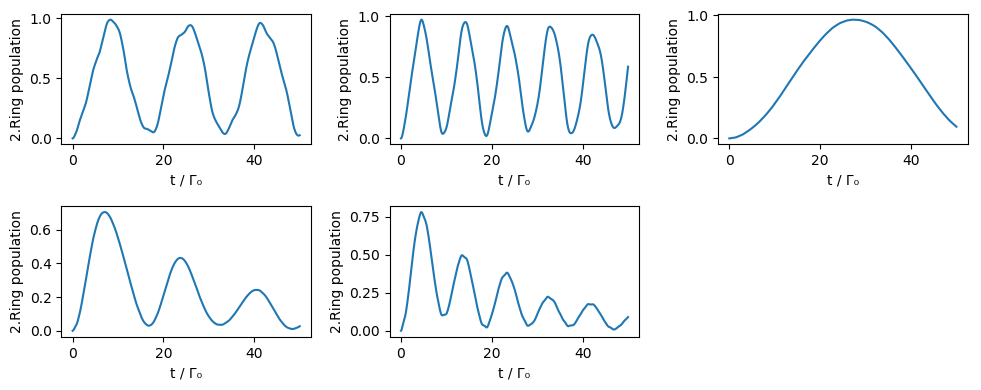

In [9]:
function projector(psi)
    acc = 0.0
    for i = N1+1:N2
        acc += expect(sp(i)*sm(i),psi)
    end
    return acc
end

figure(figsize=(10, 4))
for i = 1:5
    psi0 = λ[2][end+1-i]
    tout,psit = timeevolution.schroedinger(tspan,psi0,Heff)
    subplot(2,3,i)
    plot(tout,projector.(psit))
    xlabel("t / Γ₀")
    ylabel("2.Ring population")
end

tight_layout()

Finally we look at a chain of 25 dipole emitters polarized in the direction of the chain and plot the most subradiant state.

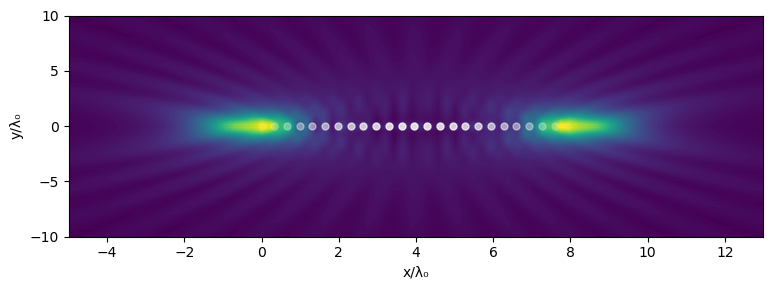

In [11]:
d = 0.33
N = 25
pos = CollectiveSpins.geometry.box(d,d,d, Nx=1,Ny=N,Nz=1)
dips = [[0.0,1.0,0.0] for i=1:N]

Ω(i,j) = Omega_ij(pos[i],pos[j],dips[i],dips[j],k0)
Γ(i,j) = Gamma_ij(pos[i],pos[j],dips[i],dips[j],k0)

b = NLevelBasis(N)
sm(i) = transition(b, N, i)
sp(i) = transition(b, i, N)

Heff = sum((Ω(i,j)-1im*Γ(i,j)*0.5)*sp(i)*sm(j) for i=1:N,j=1:N)
psi = eigenstates(dense(Heff))[2][end]

x = collect(range(-10.0, stop=10.0, length=80))
y = collect(range(-5.0, stop=13.0, length=80))
z = 3d
grid =[[x1, y1, z1] for x1=x, y1=y, z1=z];

I_exp(r, ψ) = real(expect(Intensity(r,N), ψ));

I_profile = [I_exp(gr,psi) for gr=grid];

figure(figsize=(8, 3))
contourf(y, x, I_profile, 200,cmap="viridis")
for i = 1:N
    alpha_ = abs.(dagger(nlevelstate(b,i))*psi)
    plot(pos[i][2],pos[i][1],"wo",markersize=5,alpha=3*alpha_)
end
xlabel("x/λ₀")
ylabel("y/λ₀")

tight_layout()